In [3]:
cd /home/disk2/wdd/PDZ/12concentration_MSM_Q

/home/disk2/wdd/PDZ/12concentration_MSM_Q


In [2]:
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
from msmbuilder.lumping import PCCA
from msmbuilder.msm import implied_timescales
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/disk2/wdd/msm/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
import mdtraj as md
nt=1
t_con=md.load('/home/disk2/wdd/PDZ/12concentration/fit'+str(nt)+'.xtc',top='/home/disk2/wdd/PDZ/12concentration/begin.pdb',stride=10)

In [13]:
binding_ca = []
for ri in range(20,30)+range(71,80):
    binding_ca+=[atom.index for atom in t_con.topology.residue(ri).atoms if (atom.name in ['CA'])]
binding_ca
#for ri in t_con.topology.residues:
#    print r
#r.atoms

[339,
 353,
 360,
 379,
 386,
 406,
 420,
 439,
 458,
 465,
 1060,
 1077,
 1092,
 1109,
 1119,
 1129,
 1148,
 1158,
 1177]

In [19]:
import mdtraj as md
#for nt in [1]:
#all_dist=[]
for nt in [1,2,3,4,5,6,7,8,10,11,12]:
    t_con=md.load('/home/disk2/wdd/PDZ/12concentration/fit'+str(nt)+'.xtc',top='/home/disk2/wdd/PDZ/12concentration/begin.pdb',stride=10)
    for i in range(1,13):
        pdz_ca=[atom.index for atom in t_con.topology.chain(i).atoms if ((atom.residue.index > (109+6*i) and atom.residue.index <= (114+6*i)) and (atom.name in ['CA']))]
        binding_ca = []
        for ri in range(20,30)+range(71,80):
            binding_ca+=[atom.index for atom in t_con.topology.residue(ri).atoms if (atom.name in ['CA'])]
        atom_pairs=[]
        for cc in binding_ca:
            for pc in pdz_ca:
                atom_pairs.append([cc,pc])       
        distances=md.compute_distances(t_con,atom_pairs=atom_pairs)
        #distances_ave=np.mean(distances,axis=1)
        outname1='fit'+str(nt)+'_pdz'+str(i)+'_0-5000.cs'
        wf=open(outname1,'w')
        for dist in distances[0:5001]:
            for di in dist:
                wf.write(str(di)+'    ')
            wf.write('\n')
        wf.close()
        outname2='fit'+str(nt)+'_pdz'+str(i)+'_5000-10000.cs'
        wf=open(outname2,'w')
        for dist in distances[5000:10001]:
            for di in dist:
                wf.write(str(di)+'    ')
            wf.write('\n')
        wf.close()
        #all_dist.append(distances)

In [17]:
len(distances)

10001

In [20]:
import glob
files=glob.glob('*.cs')
wf=open('xtc_sortname.dat','w')
all_dist=[]
for ff in files:
    wf.write(ff+'\n')
    data=np.loadtxt(ff)
    all_dist.append(data)
wf.close()

In [24]:
all_dist_arr=np.array(all_dist)

In [25]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_dists = scaler.fit_transform(all_dist_arr)

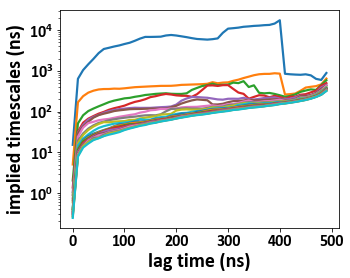

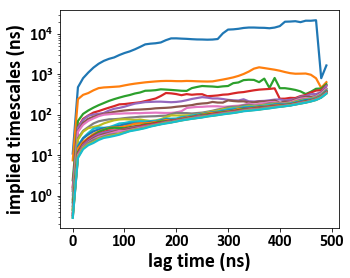

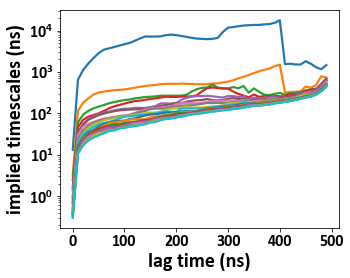

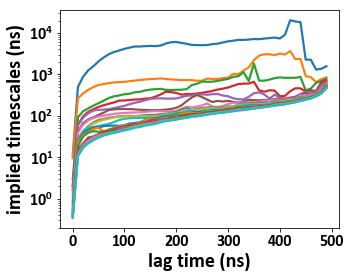

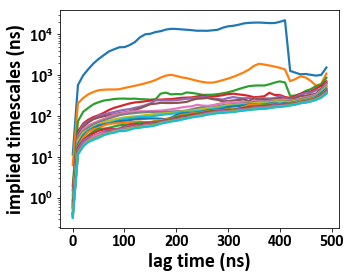

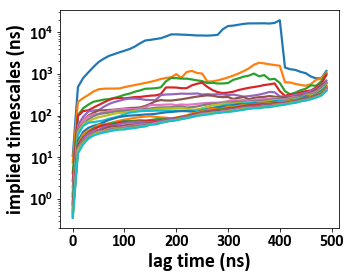

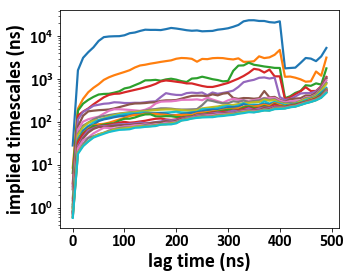

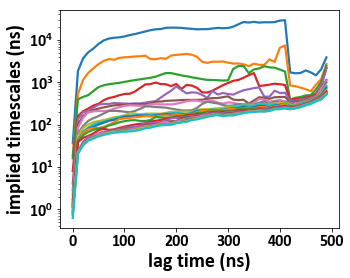

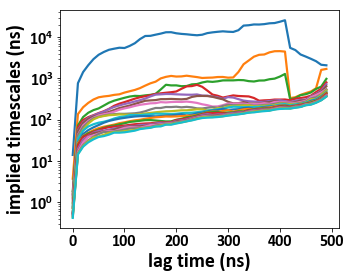

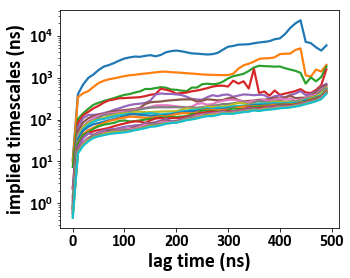

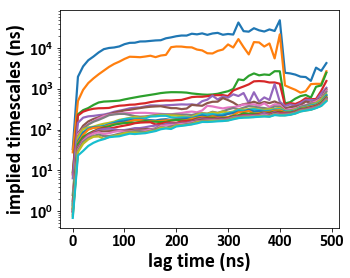

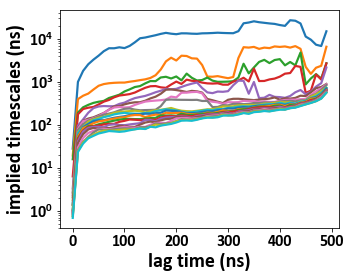

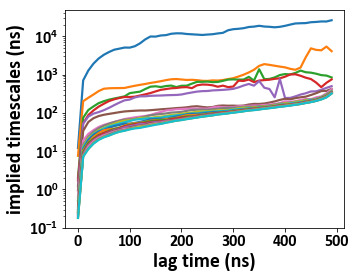

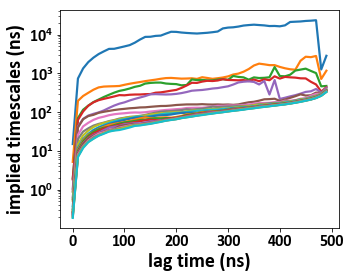

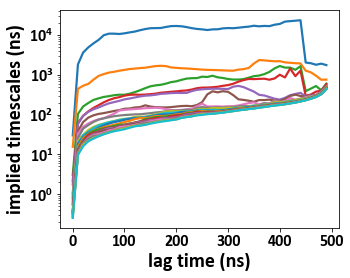

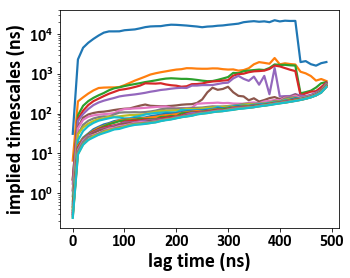

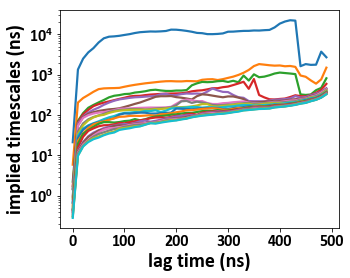

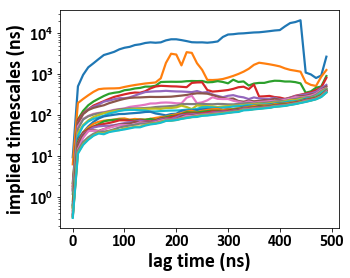

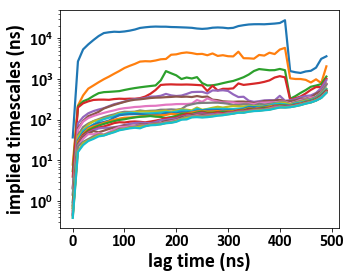

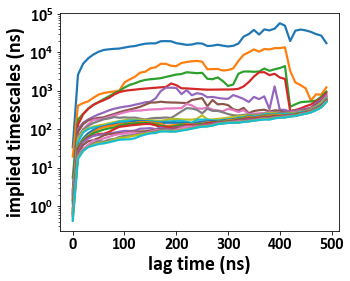

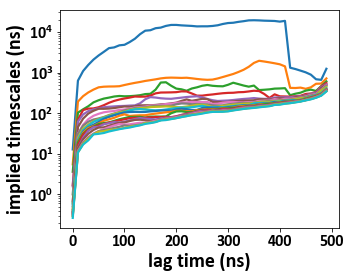

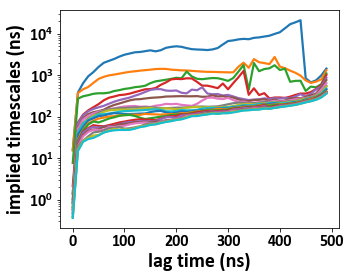

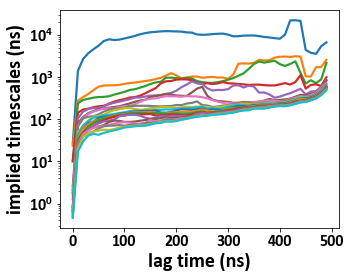

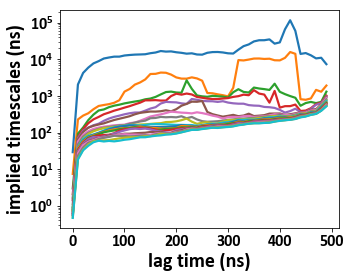

In [31]:
from msmbuilder.decomposition import tICA
#tica_lag=[50,100,200,500,800]
tica_lag=[250,500]
num_components=[4,6,8]
num_clusters=[400,450,800,900]
for tlag in tica_lag:
    for ncom in num_components:
        #tica_model = tICA(lag_time=tlag, n_components=ncom,kinetic_mapping=True)
        tica_model = tICA(lag_time=tlag, n_components=ncom,kinetic_mapping=True)
        #tica_dir='ticas_lag'+str(tlag)+'ncom'+str(ncom)+'/'
        #tica_model = scaled_diheds.fit_with(tica_model)
        tica_model.fit(scaled_dists)
        tica_trajs = tica_model.transform(scaled_dists)
        #tica_trajs = scaled_diheds.transform_with(tica_model, tica_dir, fmt='dir-npy')
        for nc in num_clusters:
            clusterer = MiniBatchKMedoids(n_clusters=nc, random_state=42)
            #cluster_dir='kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)+'/'
            #clustered_trajs = tica_trajs.fit_transform_with(clusterer, cluster_dir, fmt='dir-npy')
            clustered_trajs = clusterer.fit_transform(tica_trajs)
            lag_times = np.arange(1,5000,100)
            n_timescales = 20
            msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)
            fig = plt.figure(figsize=(5,4))
            sub = fig.add_subplot(1,1,1)
            for i in range(n_timescales):
                plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
            for label in (sub.get_xticklabels() + sub.get_yticklabels()):
                label.set_fontproperties(font_prop)
                label.set_fontsize(16)
            plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
            plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
            #plt.ylim(1,10000)
            plt.semilogy()
            pngname='impliedtimescales_kmedoids_mapTrue'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)
            plt.savefig(pngname,dpi=600,bbox_inches='tight')
            plt.show()

In [142]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=300, n_components=5)
# fit and transform can be done in seperate steps:
#tica_model.fit(scaled_dists)
#tica_trajs = tica_model.transform(scaled_dists)
tica_model.fit(all_dist_arr)
tica_trajs = tica_model.transform(all_dist_arr)

In [143]:
clusterer = MiniBatchKMedoids(n_clusters=450, random_state=42)

In [144]:
clustered_trajs = clusterer.fit_transform(tica_trajs)

In [112]:
lag_times = np.arange(1,2500,25)
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 4)

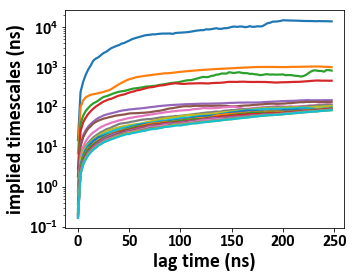

In [113]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
#plt.xlim(-1,50)
#plt.ylim(1,1000)
plt.semilogy()
plt.savefig('impliedtimescales_tica4_lag1000_kmedoids500.png',dpi=600,bbox_inches='tight')
plt.show()

In [124]:
msm=MarkovStateModel(lag_time=300,reversible_type='mle', ergodic_cutoff='off',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')

In [116]:
mkdir micro500_la750_tica4lag1000

In [117]:
cd micro500_la750_tica4lag1000

/home/disk2/wdd/PDZ/12concentration_MSM/micro500_la750_tica4lag1000


In [118]:
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()

In [119]:
import mdtraj.io as mdio
from msmbuilder.io import save_meta,load_meta
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')

In [139]:
tica_trajs[0][0]

array([ 0.20263479, -0.2409693 , -1.03355064,  0.94107853, -0.29699353])

In [146]:
#save tica traj
rf=open('xtc_sortname.cs','r')
filename=rf.readlines()
for trj in range(len(tica_trajs)):
    outname=filename[trj].split('.')[0]+'.tica'
    wf=open(outname,'w')
    for fra in range(len(tica_trajs[trj])):
        for tic in range(len(tica_trajs[trj][fra])):
            wf.write(str(tica_trajs[trj][fra][tic])+'    ')
        wf.write('\n')
    wf.close()

In [145]:
pwd

u'/home/disk2/wdd/PDZ/12concentration_MSM'

In [147]:
all_dist_arr[0][0]

array([ 3.78217,  3.60895,  3.31307,  3.31575,  3.03655,  3.99434,
        3.79336,  3.50654,  3.54281,  3.26979,  4.18067,  3.97391,
        3.67413,  3.72987,  3.48253,  4.047  ,  3.81396,  3.52557,
        3.61726,  3.38299,  4.39084,  4.14532,  3.86515,  3.97086,
        3.73833,  4.60414,  4.34443,  4.08413,  4.19778,  3.95199,
        4.54521,  4.65387,  4.45904,  4.56942,  4.31996,  4.48831,
        4.56855,  4.73953,  4.86259,  4.61168,  4.21659,  4.28019,
        4.65096,  4.66604,  4.78572,  4.03548,  4.07612,  4.44952,
        4.49166,  4.62109,  4.30613,  4.39834,  4.76192,  4.73877,
        4.83183,  4.58178,  4.68182,  4.92545,  4.99588,  4.70156,
        4.37663,  4.49716,  4.84818,  4.78385,  4.80911,  4.26907,
        4.40349,  4.75543,  4.69462,  4.6405 ,  4.62875,  4.76358,
        4.53531,  4.59242,  4.30424,  4.72941,  4.8564 ,  4.60166,
        4.63081,  4.32527,  4.44354,  4.60967,  4.70458,  4.72456,
        4.43009,  4.54821,  4.67221,  4.38917,  4.41997,  4.13

In [148]:
scaled_dists[0][0]

array([ 0.19077212,  0.08424066, -0.09302238, -0.10767068, -0.28088249,
        0.35703132,  0.24396453,  0.08683013,  0.08096515, -0.09884027,
        0.4967608 ,  0.37085572,  0.21032508,  0.22805328,  0.06614031,
        0.44299672,  0.30385198,  0.14503718,  0.19088277,  0.037131  ,
        0.63665794,  0.49334777,  0.35037072,  0.40802964,  0.26367243,
        0.74576613,  0.59798783,  0.46925287,  0.53707976,  0.38996453,
        0.70276494,  0.7453429 ,  0.66166438,  0.73206168,  0.59212149,
        0.68337441,  0.72510735,  0.82457038,  0.89636172,  0.74186204,
        0.52216865,  0.55133654,  0.75182158,  0.76079804,  0.80021065,
        0.40945047,  0.43167903,  0.62730798,  0.63498801,  0.68424915,
        0.55206326,  0.59575321,  0.79380866,  0.78576924,  0.82760534,
        0.67739284,  0.74314593,  0.88326435,  0.93971896,  0.74236317,
        0.56966962,  0.64195304,  0.84763736,  0.81007269,  0.80672109,
        0.52592752,  0.5948326 ,  0.80479647,  0.76877617,  0.72